### Домашнее задание 4 «Модели авторегрессии условной гетероскедантичности»

### Задание

1. Выберите ряд из первого задания.  
2. Постройте его модель GARCH.  
3. Оформите отчёт в Jupyter-ноутбук.  

In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import tqdm

import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa import arima
from statsmodels.tsa.ar_model import ar_select_order

from arch.univariate import arch_model

from scipy.stats import boxcox
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [4]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

In [13]:
# "Monthly sales of company X"
series = pd.read_csv('D:\\Git_repos\\time_series\\data\\Series\\monthly-sales-of-company-x-jan-6.csv')['Count']

Results of Dickey-Fuller Test:
Test Statistic                  0.654715
p-value                         0.988889
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


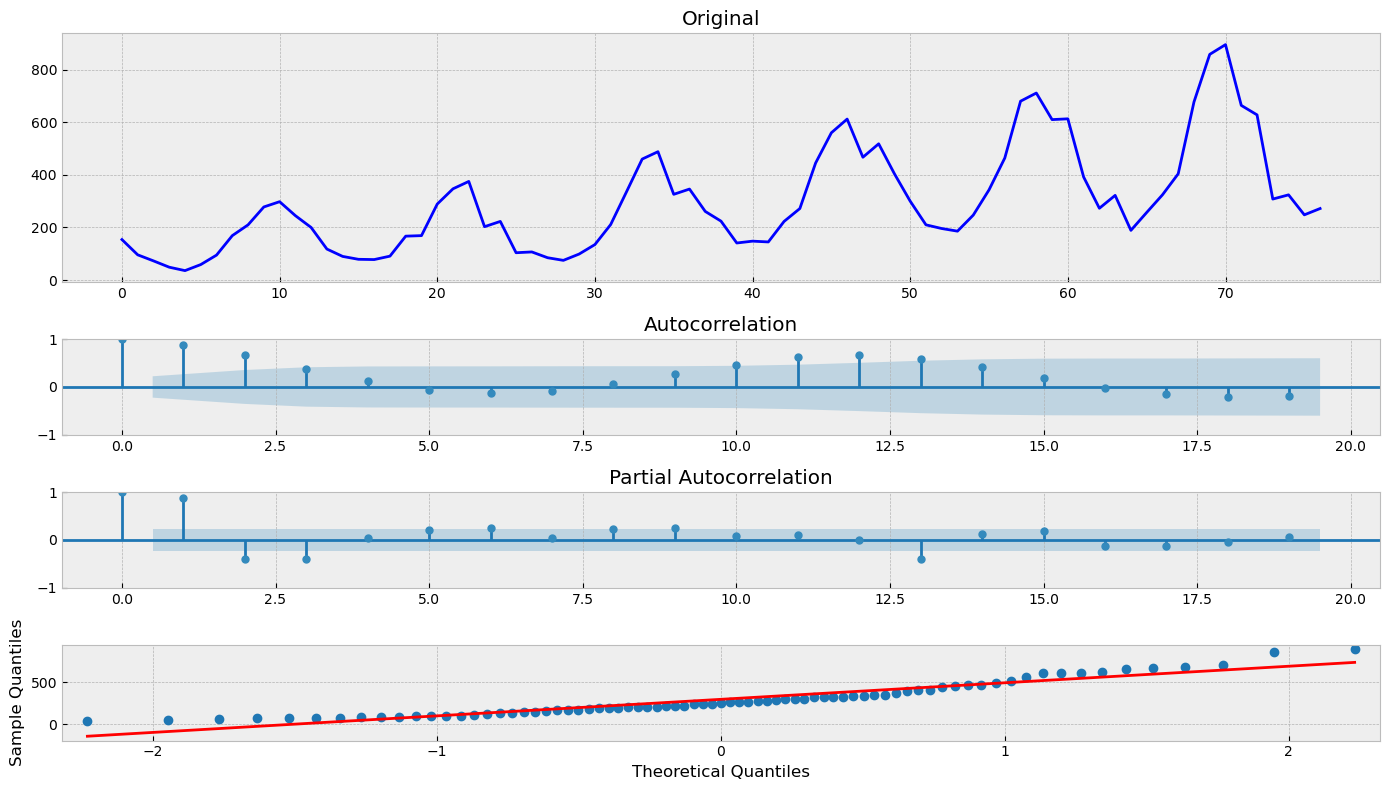

In [14]:
tsplot(series)

## Модель GARCH

Применяю преобразование Бока-Кокса для приближения к нормальному распределению,  
устраняю тренд (лаг 1) и сезонность (лаг 6)

In [15]:
series = boxcox(series, 0)
series = series[1:] - series[:-1]
series = series[12:] - series[:-12]

Results of Dickey-Fuller Test:
Test Statistic                 -2.316045
p-value                         0.166845
#Lags Used                     10.000000
Number of Observations Used    53.000000
Critical Value (1%)            -3.560242
Critical Value (5%)            -2.917850
Critical Value (10%)           -2.596796
dtype: float64


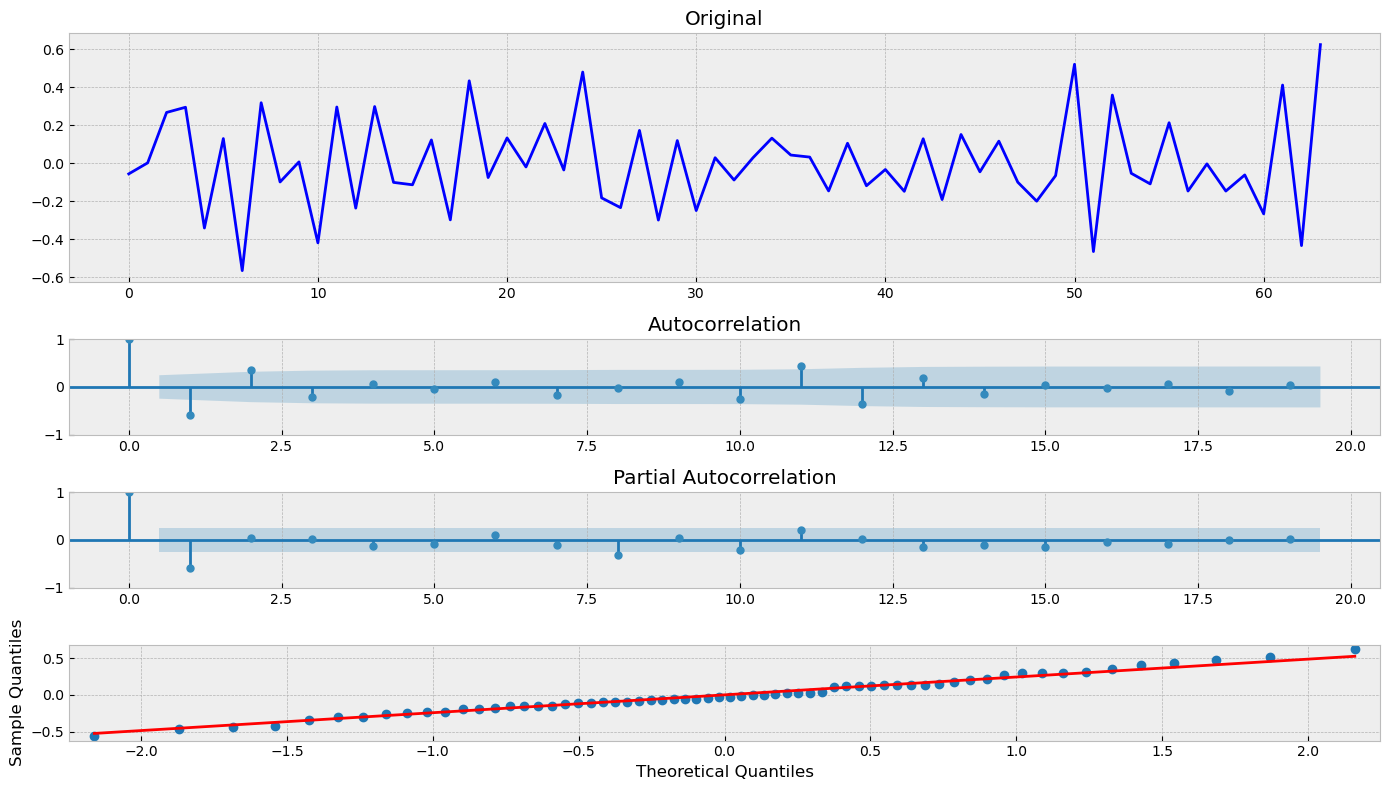

In [16]:
tsplot(series)

Ряд ещё не стационарный, согласно тесту Дики-Фуллера.  
График автокорреляции показывает пики на лагах 2 и 11. Уберу сезонность с такими периодами.

Results of Dickey-Fuller Test:
Test Statistic                -8.566484e+00
p-value                        8.419534e-14
#Lags Used                     1.000000e+00
Number of Observations Used    4.900000e+01
Critical Value (1%)           -3.571472e+00
Critical Value (5%)           -2.922629e+00
Critical Value (10%)          -2.599336e+00
dtype: float64


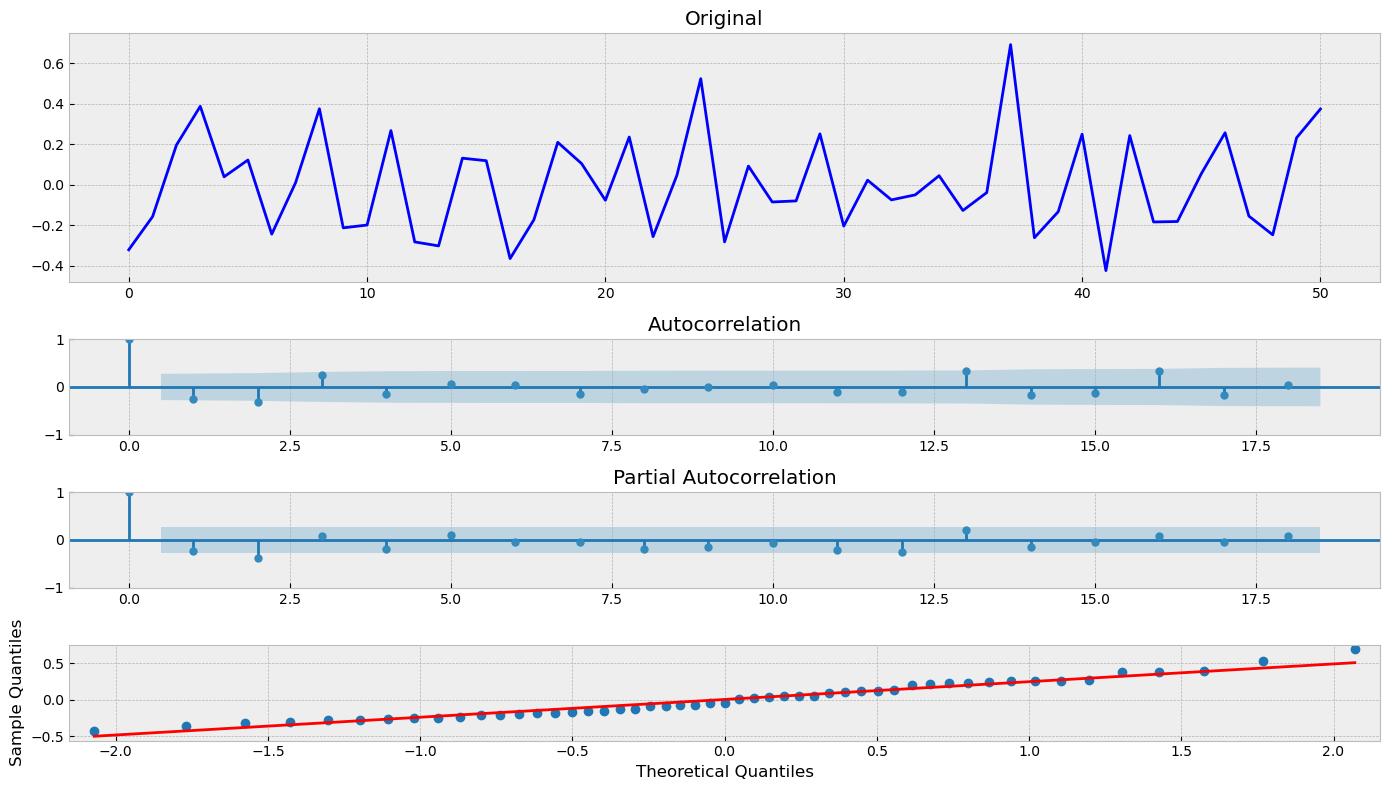

In [17]:
series = series[2:] - series[:-2]
series = series[11:] - series[:-11]
tsplot(series)

Сам ряд становится похожим на стационарный, но дисперсия (ряд возведённый в квадрат) не проходит тест Дики-Фуллера.

Results of Dickey-Fuller Test:
Test Statistic                -7.317268e+00
p-value                        1.220005e-10
#Lags Used                     0.000000e+00
Number of Observations Used    5.000000e+01
Critical Value (1%)           -3.568486e+00
Critical Value (5%)           -2.921360e+00
Critical Value (10%)          -2.598662e+00
dtype: float64


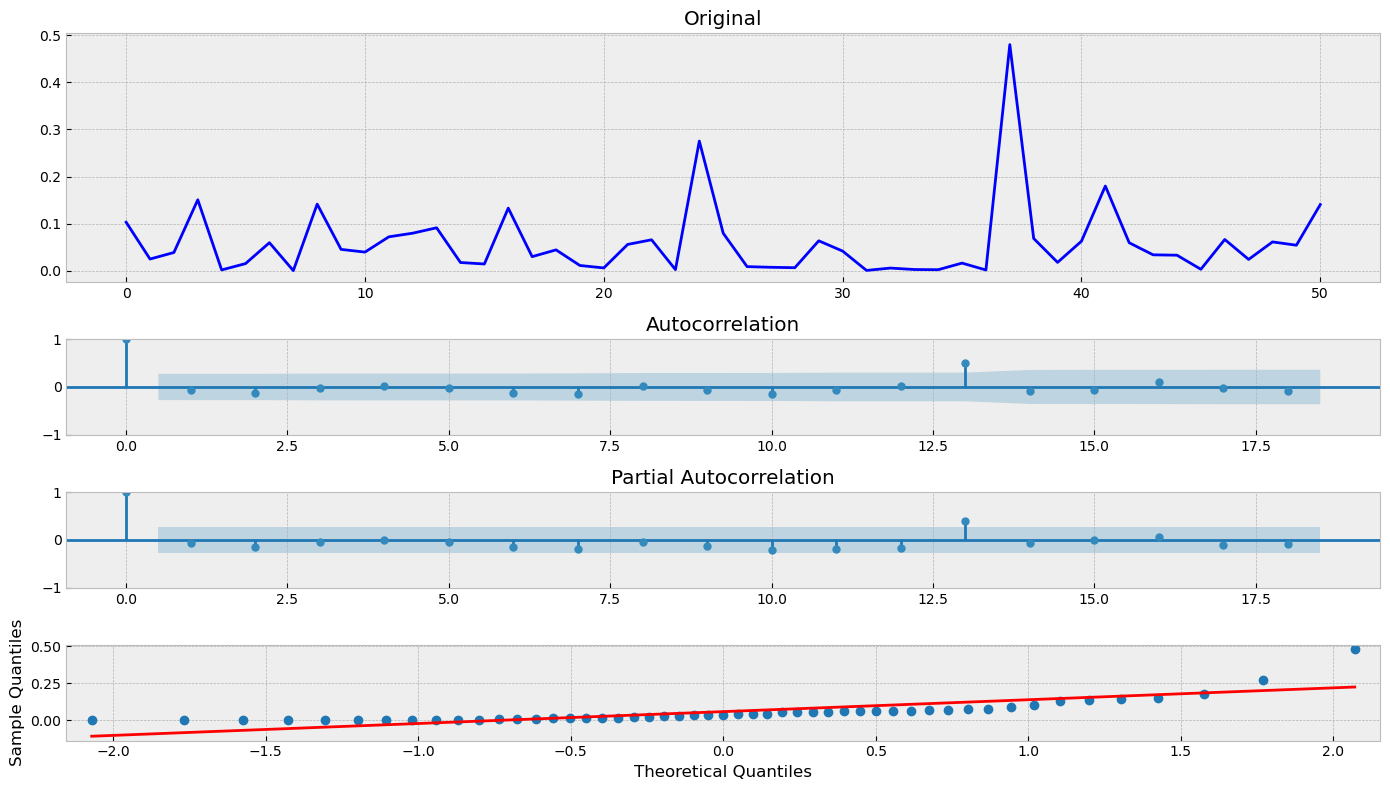

In [18]:
tsplot(series**2)

In [19]:
def _get_best_model(TS):    
    best_aic = np.inf 
    best_order = None
    best_mdl = None
    for i in range(5):
        for d in range(5):
            for j in range(5):
                try:
                    tmp_mdl = smt.arima.ARIMA(series, order=(i,d,j), trend='n').fit()
                    tmp_aic = tmp_mdl.aic

                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue    
    
    return best_aic, best_order, best_mdl

In [20]:
import warnings
warnings.filterwarnings('ignore')

aic, order, mdl = _get_best_model(series)

In [21]:
print(f'aic: {aic:6.5f} | order: {order}')

aic: -8.92571 | order: (1, 0, 4)


In [22]:
mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   51
Model:                 ARIMA(1, 0, 4)   Log Likelihood                  10.463
Date:                Thu, 07 Dec 2023   AIC                             -8.926
Time:                        11:07:24   BIC                              2.665
Sample:                             0   HQIC                            -4.496
                                 - 51                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6367      0.481      1.324      0.185      -0.306       1.579
ma.L1         -1.1537      6.020     -0.192      0.848     -12.953      10.646
ma.L2         -0.1448      1.067     -0.136      0.892      -2.236       1.946
ma.L3          0.7689      1.799      0.428      0.669      -2.756       4.294
ma.L4         -0.4686      2.698     -0.174      0.862      -5.757       4.820
sigma2         0.0365      0.212      0.172      0.863      -0.379       0.452
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                 6.03
Prob(Q):                              0.75   Prob(JB):                         0.05
Heteroskedasticity (H):               1.03   Skew:                             0.82
Prob(H) (two-sided):                  0.96   Kurtosis:                         3.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Results of Dickey-Fuller Test:
Test Statistic                -6.420932e+00
p-value                        1.792346e-08
#Lags Used                     0.000000e+00
Number of Observations Used    5.000000e+01
Critical Value (1%)           -3.568486e+00
Critical Value (5%)           -2.921360e+00
Critical Value (10%)          -2.598662e+00
dtype: float64


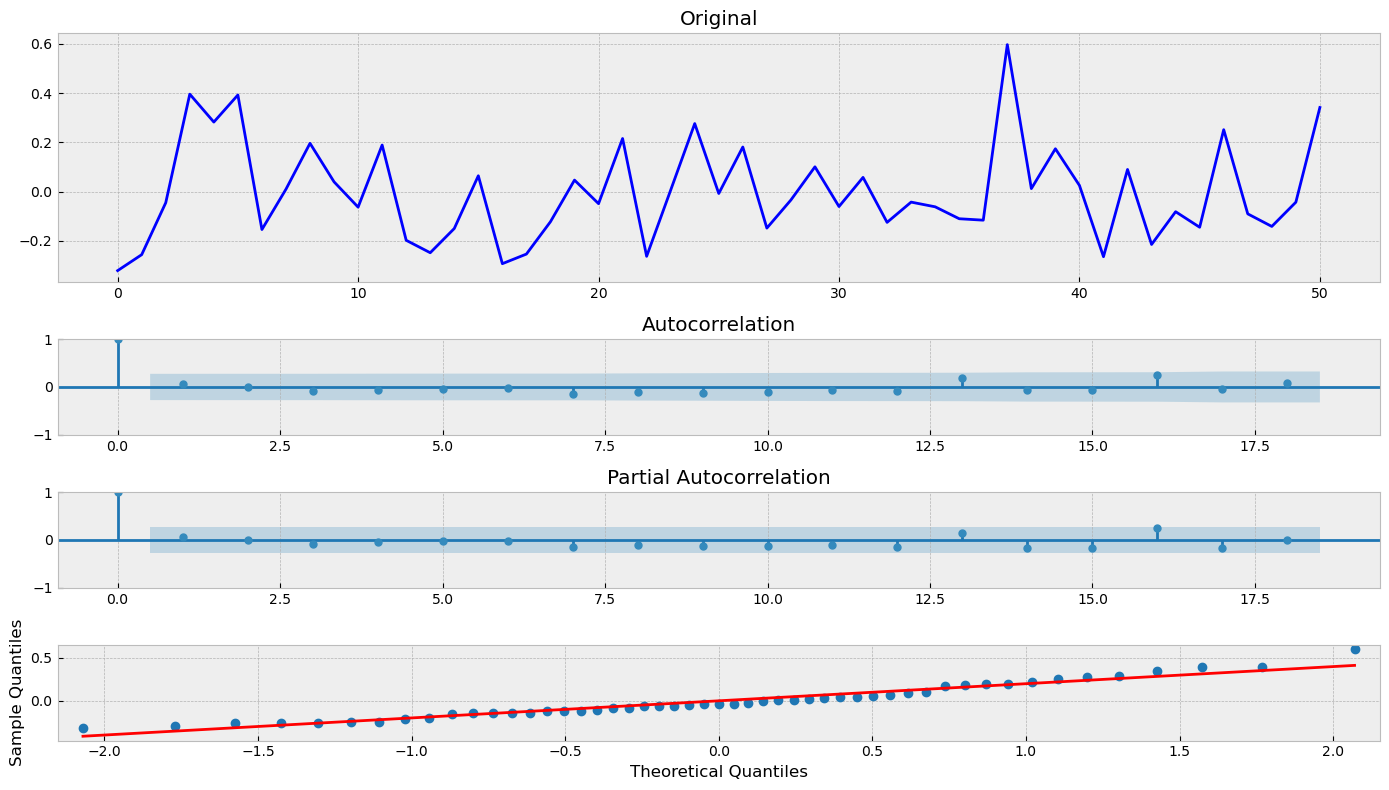

In [23]:
tsplot(mdl.resid)

Остатки ряда модели ARIMA(1, 0, 4) стационарны.

In [24]:
p_ = order[0]
o_ = order[1]
q_ = order[2]

am = arch_model(series, p=p_, o=o_, q=q_,  vol='GARCH', dist='StudentsT', rescale=False)
res = am.fit(update_freq=5, disp='off')

In [25]:
print(res.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:             -0.0638924
Distribution:      Standardized Student's t   AIC:                           16.1278
Method:                  Maximum Likelihood   BIC:                           31.5824
                                              No. Observations:                   51
Date:                      Thu, Dec 07 2023   Df Residuals:                       50
Time:                              11:11:08   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
m

Results of Dickey-Fuller Test:
Test Statistic                -8.566484e+00
p-value                        8.419534e-14
#Lags Used                     1.000000e+00
Number of Observations Used    4.900000e+01
Critical Value (1%)           -3.571472e+00
Critical Value (5%)           -2.922629e+00
Critical Value (10%)          -2.599336e+00
dtype: float64


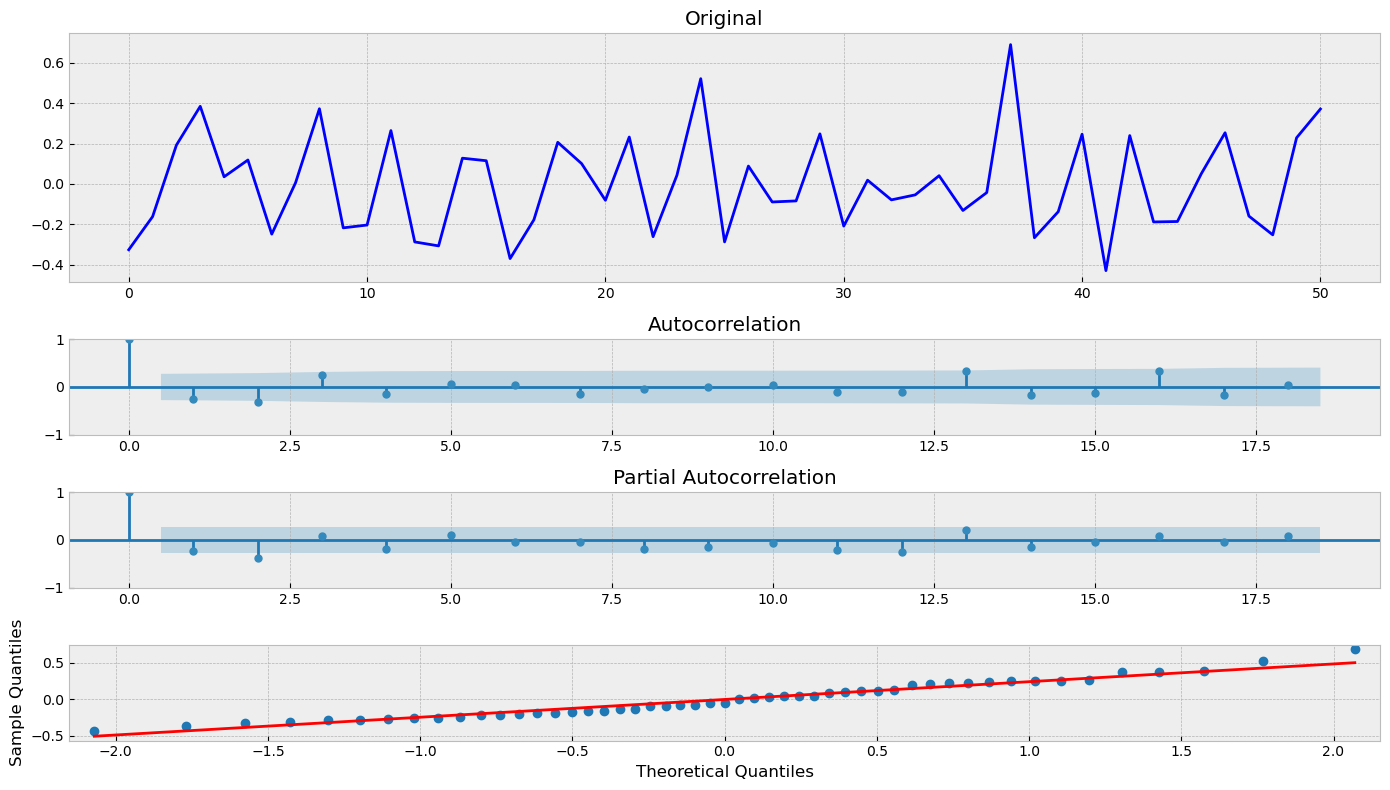

In [26]:
tsplot(res.resid)

Results of Dickey-Fuller Test:
Test Statistic                -7.306101e+00
p-value                        1.300325e-10
#Lags Used                     0.000000e+00
Number of Observations Used    5.000000e+01
Critical Value (1%)           -3.568486e+00
Critical Value (5%)           -2.921360e+00
Critical Value (10%)          -2.598662e+00
dtype: float64


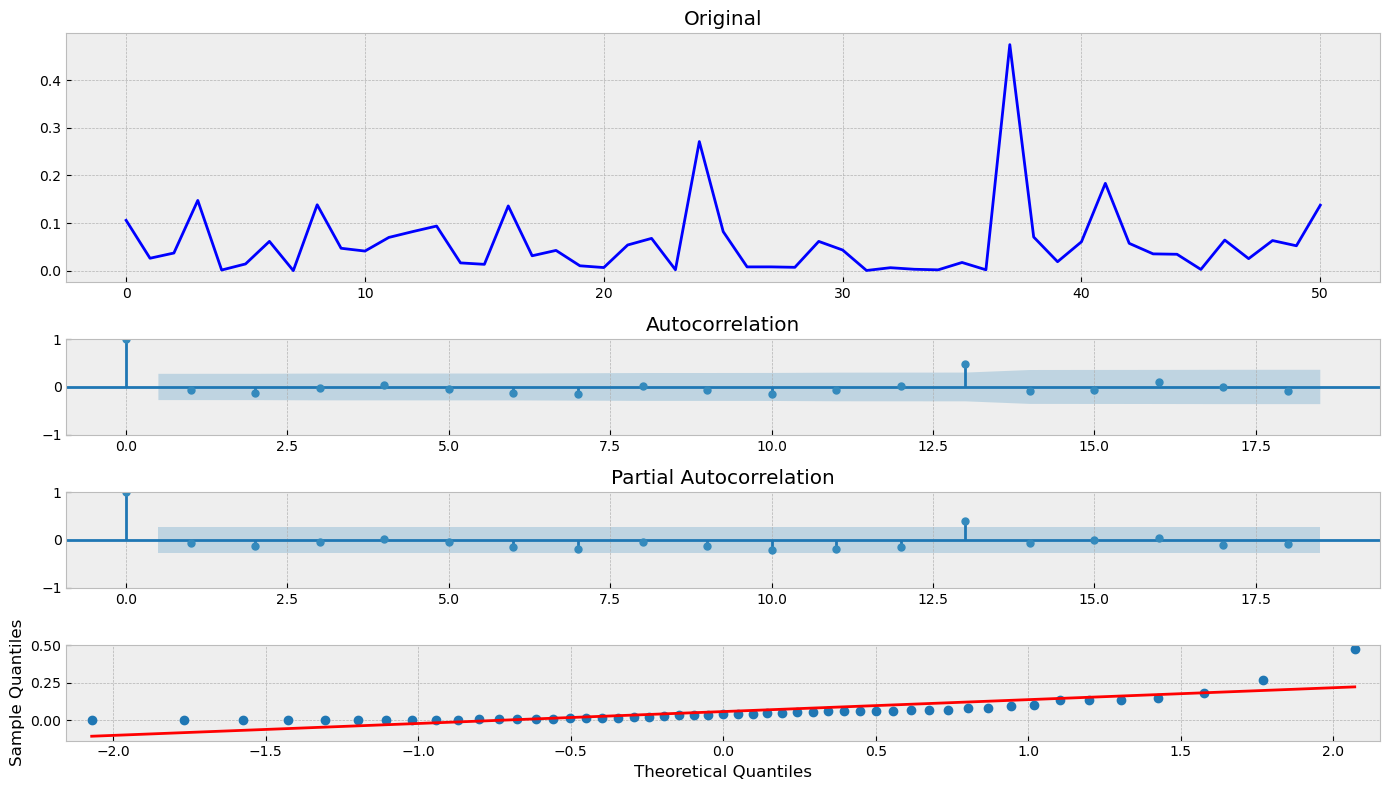

In [27]:
tsplot(res.resid**2)

Results of Dickey-Fuller Test:
Test Statistic                 -2.544540
p-value                         0.105010
#Lags Used                      2.000000
Number of Observations Used    48.000000
Critical Value (1%)            -3.574589
Critical Value (5%)            -2.923954
Critical Value (10%)           -2.600039
dtype: float64


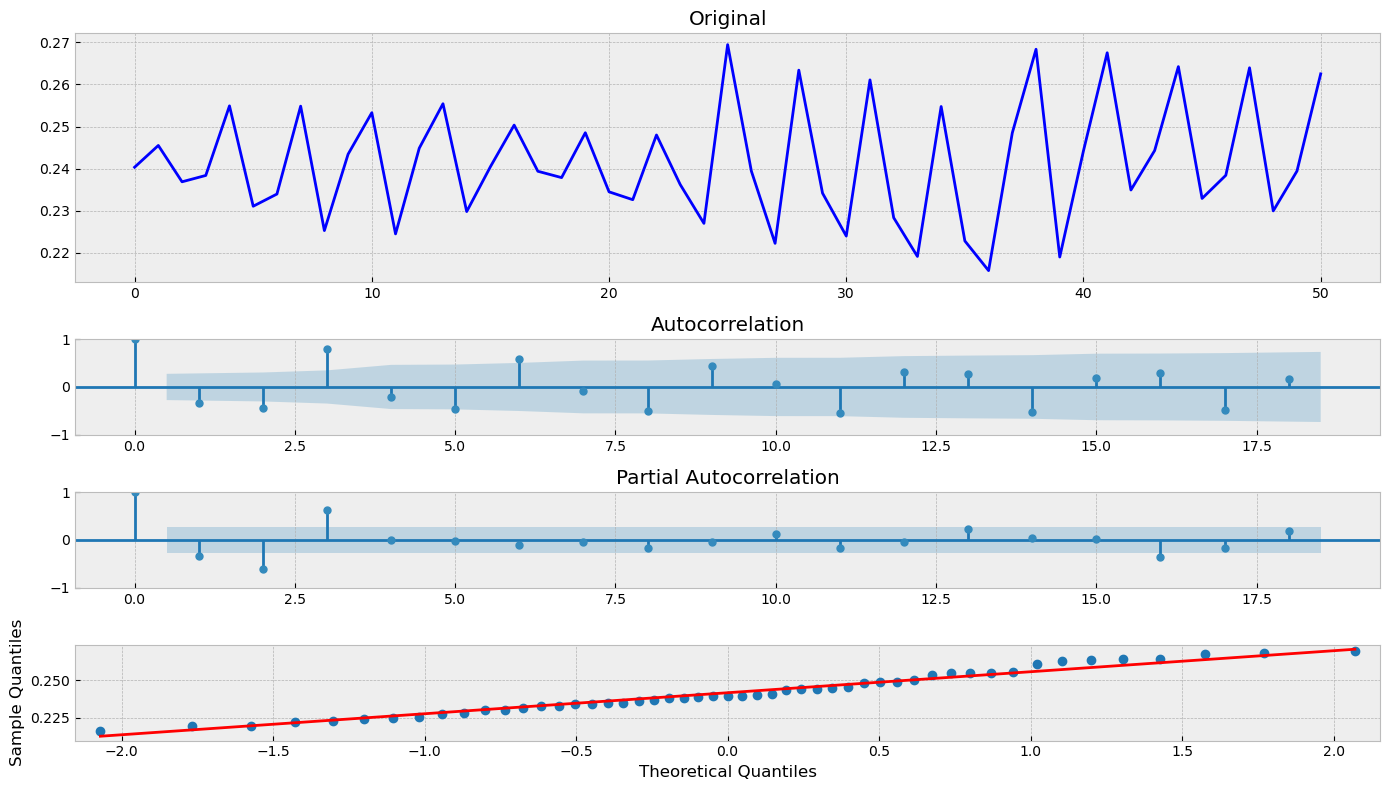

In [30]:
tsplot(res.conditional_volatility)

Условная волотильность не стационарна.   
В порядке эксперимента уберу из исходного ряда стационарность с периодом 13, замеченную на графике автокорреляции.

Results of Dickey-Fuller Test:
Test Statistic                -5.994223e+00
p-value                        1.716829e-07
#Lags Used                     1.000000e+00
Number of Observations Used    3.600000e+01
Critical Value (1%)           -3.626652e+00
Critical Value (5%)           -2.945951e+00
Critical Value (10%)          -2.611671e+00
dtype: float64


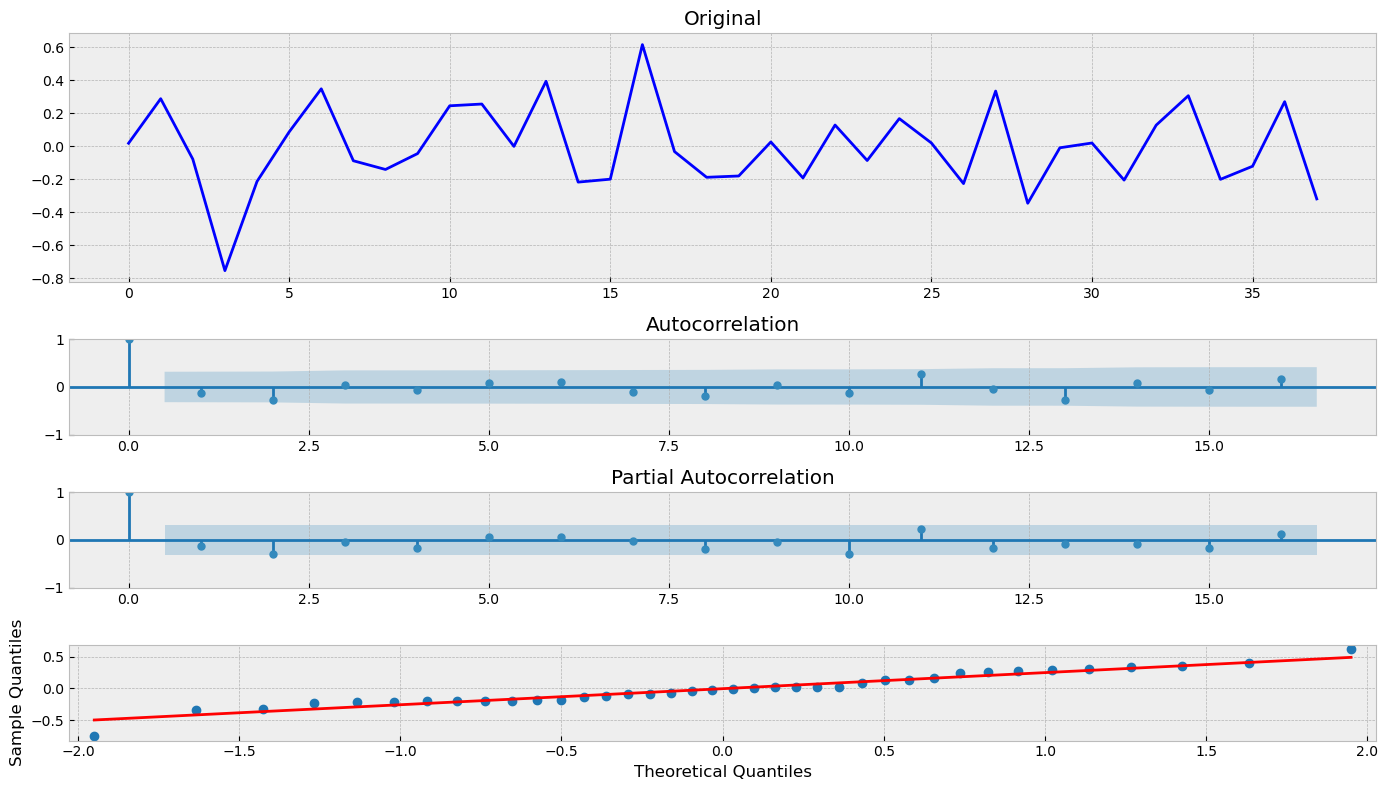

In [31]:
series = series[13:] - series[:-13]
tsplot(series)

Повторяю шаги с подбором параметров и моделью GARCH

In [32]:
import warnings
warnings.filterwarnings('ignore')

aic, order, mdl = _get_best_model(series)

In [33]:
print(f'aic: {aic:6.5f} | order: {order}')

aic: 4.21076 | order: (1, 0, 1)


In [34]:
p_ = order[0]
o_ = order[1]
q_ = order[2]

am = arch_model(series, p=p_, o=o_, q=q_,  vol='GARCH', dist='StudentsT', rescale=False)
res = am.fit(update_freq=5, disp='off')

Results of Dickey-Fuller Test:
Test Statistic                -5.994223e+00
p-value                        1.716829e-07
#Lags Used                     1.000000e+00
Number of Observations Used    3.600000e+01
Critical Value (1%)           -3.626652e+00
Critical Value (5%)           -2.945951e+00
Critical Value (10%)          -2.611671e+00
dtype: float64


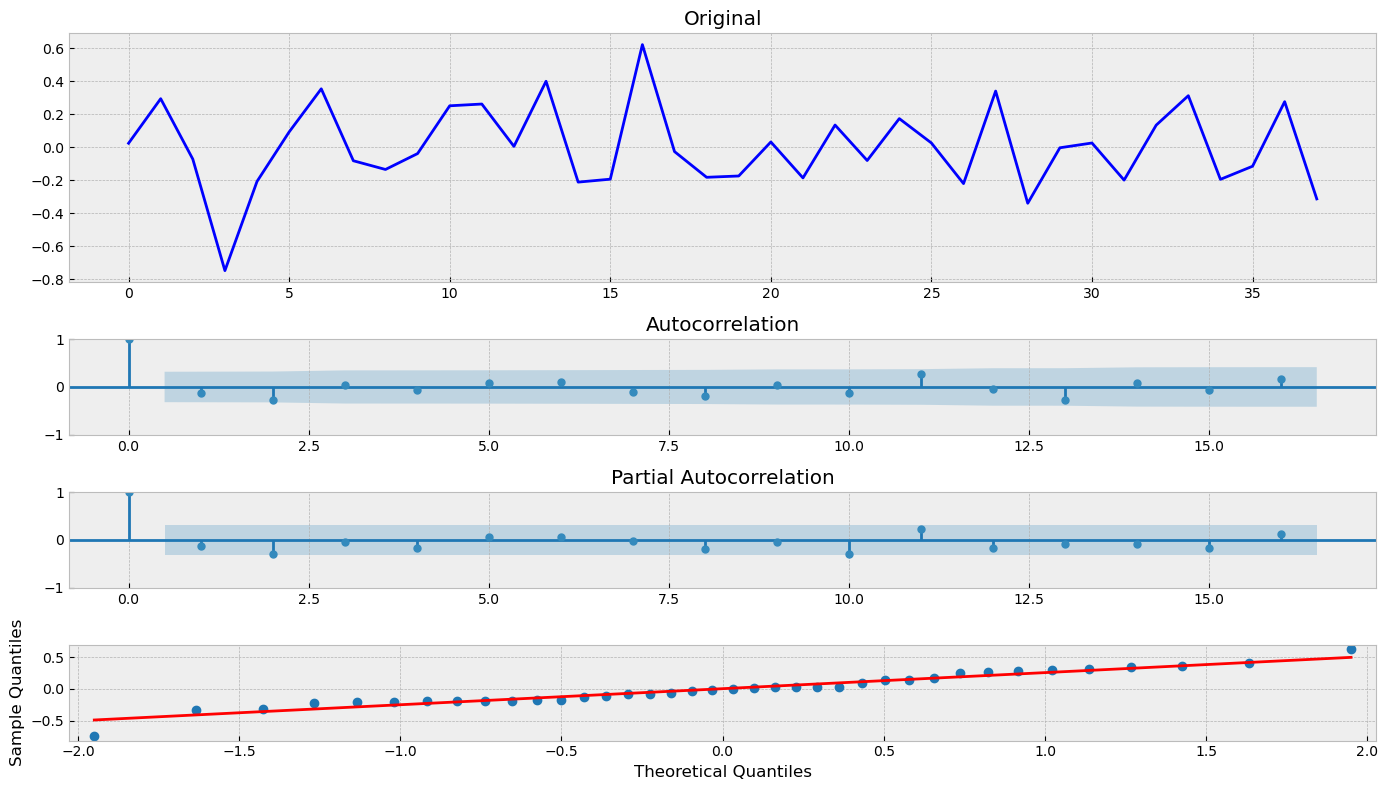

In [35]:
tsplot(res.resid)

Results of Dickey-Fuller Test:
Test Statistic                -85.279911
p-value                         0.000000
#Lags Used                      3.000000
Number of Observations Used    34.000000
Critical Value (1%)            -3.639224
Critical Value (5%)            -2.951230
Critical Value (10%)           -2.614447
dtype: float64


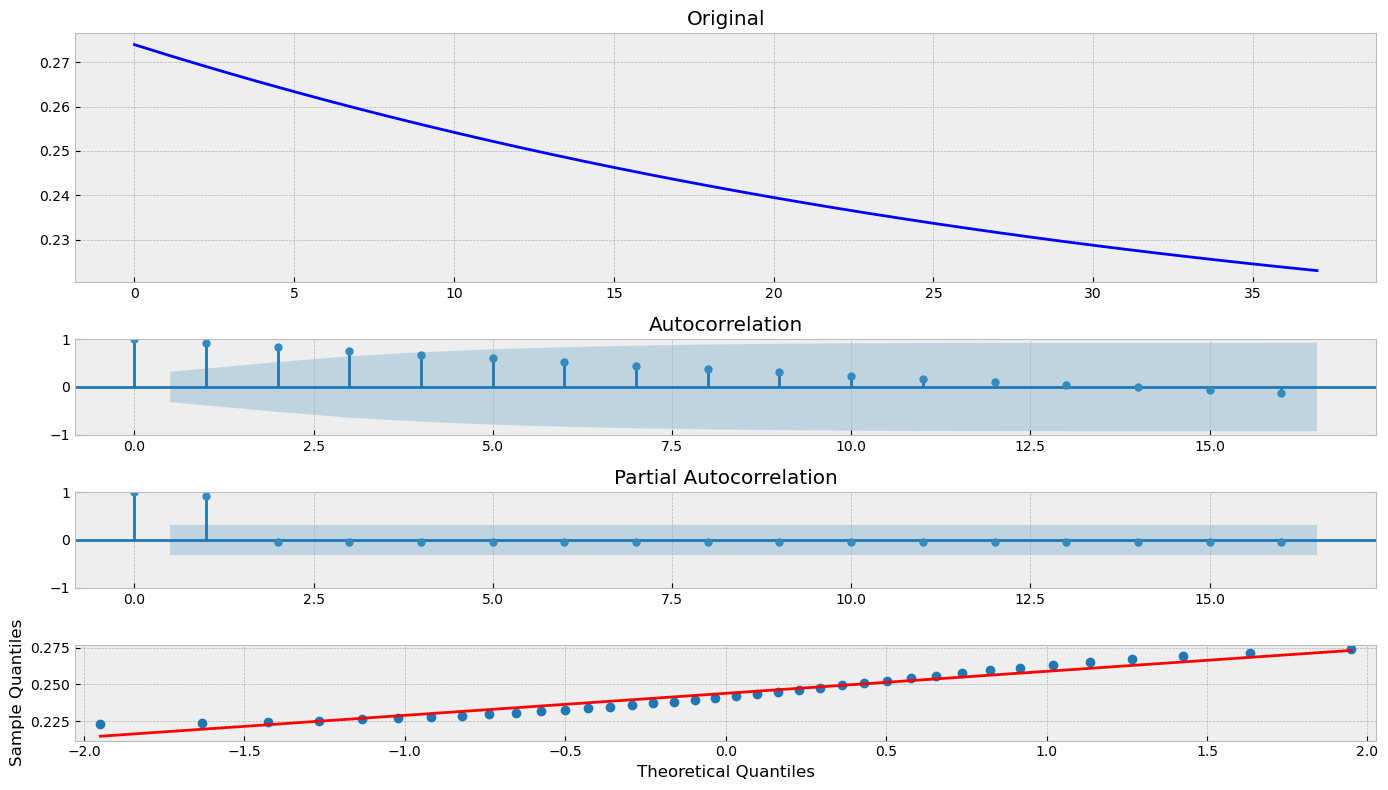

In [36]:
tsplot(res.conditional_volatility)

Полагаю, что из ряда извлечены все компоненты, делавшие его отличным от стационарного.